In [36]:
from utils.spark_session import SparkSessionManager
import os
import yaml
import logging
from datetime import datetime
from utils.spark_session import SparkSessionManager
from src.ingest import RawDataLoader
from src.clean import DataCleaner
from src.aggregate import DataAggregator
from pyspark.sql.functions import col, count, avg, sum as spark_sum, date_trunc,\
    weekofyear, year, round as spark_round, when
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_config(config_path: str = "config/config.yaml"):
    """Read configuration from YAML"""
    with open(config_path, 'r') as f:
        return yaml.safe_load(f)

In [3]:
config = load_config()
spark = SparkSessionManager.get_spark_session(
            app_name=config['spark']['app_name'],
            memory=config['spark']['memory']
        )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/27 10:46:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/27 10:46:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:

!ls data/gold/weekly_stars

_SUCCESS
part-00000-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet
part-00001-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet
part-00002-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet
part-00003-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet
part-00004-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet
part-00005-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet
part-00006-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet
part-00007-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet
part-00008-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet
part-00009-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet
part-00010-b1ccfa7f-6d31-4df4-aa90-505d88b090ac-c000.snappy.parquet


In [5]:
# Cell 2: Load Gold Data
weekly_stars = spark.read.parquet("data/gold/weekly_stars")
checkins_vs_stars = spark.read.parquet("data/gold/checkins_vs_stars")


In [6]:
print("=== DATA QUALITY SUMMARY ===")
print(f"Weekly Records: {weekly_stars.count():,}")
print(f"Businesses with Check-ins: {checkins_vs_stars.filter('total_checkins > 0').count():,}")


=== DATA QUALITY SUMMARY ===
Weekly Records: 5,138,585
Businesses with Check-ins: 131,930


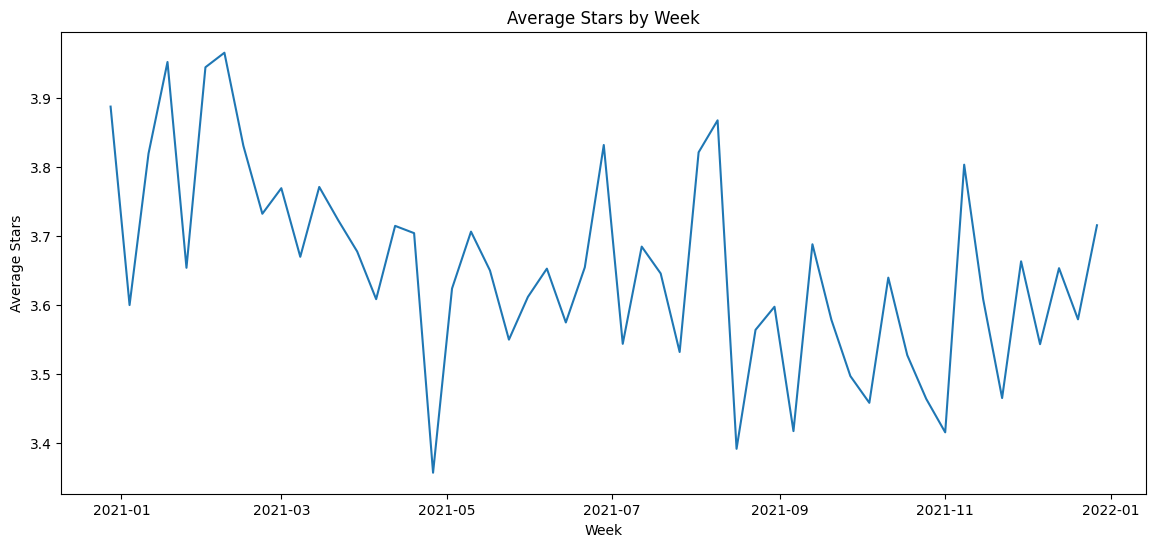

In [60]:
weekly_pd = weekly_stars.filter(col('review_year')==2021).limit(10000).toPandas()
plt.figure(figsize=(14, 6))
plt.plot(weekly_pd.groupby('review_week')['avg_stars_weekly'].mean())
plt.title('Average Stars by Week')
plt.xlabel('Week')
plt.ylabel('Average Stars')
plt.show()

Text(0.5, 1.0, 'Check-ins vs Star Rating')

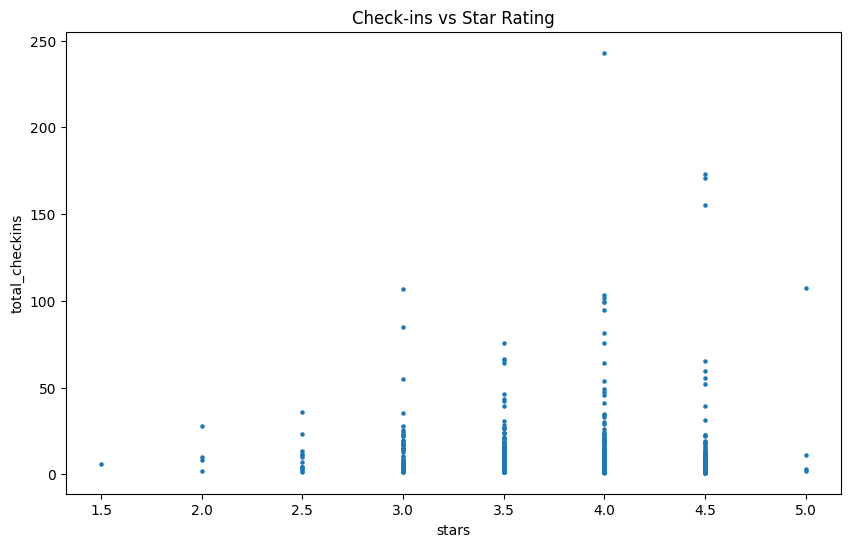

In [59]:
checkins_vs_stars_filtered = checkins_vs_stars.filter(col('total_checkins')< 20000)
checkins_pd = checkins_vs_stars_filtered.orderBy('total_checkins', ascending=False).limit(1000).toPandas()
plt.figure(figsize=(10, 6))
# Create scatter plot
plt.scatter(checkins_pd['stars'], checkins_pd['checkins_per_review'], s=5)

# Add labels and title
plt.xlabel("stars")
plt.ylabel("total_checkins")
plt.title("Check-ins vs Star Rating")

# # Show plot
# plt.show()
# sns.scatterplot(data=checkins_pd, x='stars', y='total_checkins', alpha=0.5)
# plt.title('Check-ins vs Star Rating')
# plt.show()

In [32]:
checkins_vs_stars.show(10)

+--------------------+--------------------+---------------+-----+-----+------------+--------------+-------------------+-------------+
|         business_id|       business_name|           city|state|stars|review_count|total_checkins|checkins_per_review|star_category|
+--------------------+--------------------+---------------+-----+-----+------------+--------------+-------------------+-------------+
|-1ygry5D2oOt_vch4...| New Image Detailing|Clifton Heights|   PA|  4.5|          19|             3|               0.16|    High (4+)|
|-rjyBtrqHR0VJSbLG...|          Lego Store|        Brandon|   FL|  3.5|           5|             3|                0.6| Medium (3-4)|
|1EoS8ZkUnBhcrOSWu...|Results Physiothe...|      Nashville|   TN|  3.5|           6|             3|                0.5| Medium (3-4)|
|2ci-E1rGWQEk4-UuE...|Two Mutts and a W...|   Indianapolis|   IN|  4.5|          22|             3|               0.14|    High (4+)|
|2d5pXK4LYXX_LZysL...|               Cache|  Santa Barbara|   

In [47]:
top_businesses = checkins_vs_stars.orderBy('total_checkins', ascending=False).limit(20)
top_businesses.show(truncate=False)

+----------------------+------------------------------------------------------+------------+-----+-----+------------+--------------+-------------------+-------------+
|business_id           |business_name                                         |city        |state|stars|review_count|total_checkins|checkins_per_review|star_category|
+----------------------+------------------------------------------------------+------------+-----+-----+------------+--------------+-------------------+-------------+
|-QI8Qi8XWH3D8y8ethnajA|Philadelphia International Airport - PHL              |Philadelphia|PA   |2.5  |2149        |52129         |24.26              |Medium (3-4) |
|FEXhWNCMkv22qG04E83Qjg|Café Du Monde                                         |New Orleans |LA   |4.0  |1880        |40092         |21.33              |High (4+)    |
|Eb1XmmLWyt_way5NNZ7-Pw|Louis Armstrong New Orleans International Airport  MSY|Kenner      |LA   |3.0  |1789        |37553         |20.99              |Medium (3-4) 

In [63]:
# Compare week 47 across all years
weekly_stars.filter(col('business_name') == "Pat O'Brien’s").orderBy("review_count_weekly", ascending=False).show()

# Year-over-year comparison
# weekly_stars.filter("review_week_number = 47 AND review_year IN (2023, 2024)")

+--------------------+-------------+-----------+-----+-------------------+-----------+------------------+----------------+-------------------+----------+---------+--------+
|         business_id|business_name|       city|state|        review_week|review_year|review_week_number|avg_stars_weekly|review_count_weekly|avg_useful|avg_funny|avg_cool|
+--------------------+-------------+-----------+-----+-------------------+-----------+------------------+----------------+-------------------+----------+---------+--------+
|6Ty-KKWq6hLZYW8DW...|Pat O'Brien’s|New Orleans|   LA|2018-05-21 00:00:00|       2018|                21|            3.79|                 14|      0.64|     0.14|    0.57|
|6Ty-KKWq6hLZYW8DW...|Pat O'Brien’s|New Orleans|   LA|2015-01-19 00:00:00|       2015|                 4|            3.92|                 12|      0.33|     0.42|    0.33|
|6Ty-KKWq6hLZYW8DW...|Pat O'Brien’s|New Orleans|   LA|2018-03-05 00:00:00|       2018|                10|            4.25|             

In [40]:
checkin_df = spark.read.parquet("data/silver/checkin")
business_df = spark.read.parquet("data/silver/business")
checkin_df.show(10)

+--------------------+-------------------+------------+
|         business_id|  checkin_timestamp|checkin_date|
+--------------------+-------------------+------------+
|gwvw2syC8PRor43WH...|2012-06-30 14:48:53|  2012-06-30|
|gwxNttwUgmOn3vsHY...|2013-01-04 15:48:19|  2013-01-04|
|gwxNttwUgmOn3vsHY...|2013-03-30 01:00:09|  2013-03-30|
|gwxNttwUgmOn3vsHY...|2013-07-27 19:06:04|  2013-07-27|
|gwxNttwUgmOn3vsHY...|2013-09-01 17:51:21|  2013-09-01|
|gwxNttwUgmOn3vsHY...|2014-04-08 13:37:18|  2014-04-08|
|gwxNttwUgmOn3vsHY...|2014-04-26 14:53:32|  2014-04-26|
|gwxNttwUgmOn3vsHY...|2014-05-31 13:11:04|  2014-05-31|
|gwxNttwUgmOn3vsHY...|2014-08-24 15:35:06|  2014-08-24|
|gwxNttwUgmOn3vsHY...|2015-03-28 19:43:01|  2015-03-28|
+--------------------+-------------------+------------+
only showing top 10 rows



In [41]:
checkin_counts = checkin_df.groupBy("business_id").agg(
            count("checkin_timestamp").alias("total_checkins")
        )
checkin_counts.show(10)

+--------------------+--------------+
|         business_id|total_checkins|
+--------------------+--------------+
|gz1nRaB7g2TzQHpqi...|           199|
|h-lRhCfPhnVTkcndG...|            64|
|h1N4EPorcu3DIol0h...|            91|
|h6NMfoDhT_U_qaNPS...|           248|
|hBMntvGJV9yDtosy2...|            10|
|hLlDzRaDGN-0SlEWk...|           498|
|hMLcTXMk6xif0qfBi...|           660|
|hMi8sXXPj_AwwfsEJ...|            51|
|hOCBl_QltuMzYOcb2...|            59|
|h_vkfgadg3wkDlvcF...|            94|
+--------------------+--------------+
only showing top 10 rows



In [55]:
checkin_counts = checkin_df.groupBy("business_id").agg(
            count("checkin_timestamp").alias("total_checkins")
        )

# Join with business ratings
result = business_df.join(
    checkin_counts,
    "business_id",
    "left"
).select(
    "business_id",
    "business_name",
    "city",
    "state",
    "stars",
    "review_count",
    when(col("total_checkins").isNull(), 0)
    .otherwise(col("total_checkins")).alias("total_checkins")
).withColumn(
    "checkins_per_review",
    spark_round(col("total_checkins") / col("review_count"), 2)
).withColumn(
    "star_category",
    when(col("stars") >= 4.0, "High")
    .when(col("stars") >= 2.5, "Medium")
    .otherwise("Low")
)

result.orderBy(col("total_checkins").desc()).show(10)

+--------------------+--------------------+------------+-----+-----+------------+--------------+-------------------+-------------+
|         business_id|       business_name|        city|state|stars|review_count|total_checkins|checkins_per_review|star_category|
+--------------------+--------------------+------------+-----+-----+------------+--------------+-------------------+-------------+
|-QI8Qi8XWH3D8y8et...|Philadelphia Inte...|Philadelphia|   PA|  2.5|        2149|         52129|              24.26|       Medium|
|FEXhWNCMkv22qG04E...|       Café Du Monde| New Orleans|   LA|  4.0|        1880|         40092|              21.33|         High|
|Eb1XmmLWyt_way5NN...|Louis Armstrong N...|      Kenner|   LA|  3.0|        1789|         37553|              20.99|       Medium|
|c_4c5rJECZSfNgFj7...|Tampa Internation...|       Tampa|   FL|  4.0|        1849|         37511|              20.29|         High|
|4i4kmYm9wgSNyF1b6...|Nashville Interna...|   Nashville|   TN|  3.5|         949|  

In [49]:
checkins_vs_stars.orderBy('total_checkins', ascending=False).show(5)

+--------------------+--------------------+------------+-----+-----+------------+--------------+-------------------+-------------+
|         business_id|       business_name|        city|state|stars|review_count|total_checkins|checkins_per_review|star_category|
+--------------------+--------------------+------------+-----+-----+------------+--------------+-------------------+-------------+
|-QI8Qi8XWH3D8y8et...|Philadelphia Inte...|Philadelphia|   PA|  2.5|        2149|         52129|              24.26| Medium (3-4)|
|FEXhWNCMkv22qG04E...|       Café Du Monde| New Orleans|   LA|  4.0|        1880|         40092|              21.33|    High (4+)|
|Eb1XmmLWyt_way5NN...|Louis Armstrong N...|      Kenner|   LA|  3.0|        1789|         37553|              20.99| Medium (3-4)|
|c_4c5rJECZSfNgFj7...|Tampa Internation...|       Tampa|   FL|  4.0|        1849|         37511|              20.29|    High (4+)|
|4i4kmYm9wgSNyF1b6...|Nashville Interna...|   Nashville|   TN|  3.5|         949|  

In [ ]:
spark.stop()